# Gunshot Audio Simulation

Notebook for generating simulated gunshot acoustic signals with broadband inverse frequency and inverse time decay.

## Simulated Gunshot Audio Generation

This notebook generates realistic simulated gunshot audio for testing and validation of detection algorithms.

### Features
- Generates multi-channel WAV files (4 channels for 4 sensors)
- **Broadband**: All frequencies present
- **1/_f_ amplitude**: At any time *t*, amplitude vs. frequency scales as 1/*f* (higher frequencies have lower amplitude)
- **Time decay**: Amplitudes decay as 1/*t* × 1/*f* (higher frequencies decay slower)
- Distance attenuation (inverse square) and propagation delays from source to each sensor
- Uses sensor positions from config
- Visualises spectrogram of generated waveform

In [130]:
# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

import sys
sys.path.insert(0, '../')

import numpy as np

# Simulation parameters
DURATION_S = 2.0
SAMPLE_RATE = 16000
NUM_CHANNELS = 4
BACKGROUND_NOISE_STD = 4e-5

# Gunshot parameters
GUNSHOT_POSITIONS = np.array([
    #[710.0, 478.0, 420.0], 
    #[560.0, -435.0, 120.0], 
    #[443.0, 175.0, 20.0], 
    [101.0, 175.0, 289.0]
    ])  # XYZ in meters (multiple point source)
GUNSHOT_TIME_S = [0.1]   # Time of shot (seconds from start of recording)
F_MIN_HZ = 10.0        # Lowest frequency in broadband (Hz)
F_MAX_HZ = 7990.0      # Highest (below Nyquist 8000 Hz)
DF_HZ = 10.0           # Frequency step (Hz) for discrete frequency bins
T0_DECAY_S = 0.001     # Small time offset to avoid 1/0 at t=0 (seconds)
F_DECAY = 4000.0       # Frequency decay co-efficient
T_DECAY = 0.5          # Time decay co-efficient

# Sound propagation
TEMPERATURE_C = 15.0
ALTITUDE_M = 200.0
SPEED_OF_SOUND = 331.3 + 0.606 * TEMPERATURE_C - 0.006 * ALTITUDE_M / 1000.0

OUTPUT_WAV_FILE = "./data/2026-01-31_000000.wav"
TRAJECTORY_FILE = "./data/2026-01-31_000000.log"

## Imports and Setup
- Setup SF Mono Font


In [ ]:
# Configure matplotlib for Jupyter notebook
%matplotlib inline

while True:
    import warnings
    warnings.filterwarnings('ignore', category=UserWarning, message='.*FigureCanvasAgg is non-interactive.*')

    import sys
    import importlib.util
    from pathlib import Path

    import numpy as np
    import soundfile as sf
    import matplotlib.pyplot as plt
    from matplotlib import font_manager
    import os
    from scipy.signal import spectrogram

    # Force-load project config (avneet/config.py) so config has SENSOR_MOUNT_HEIGHT_M etc.
    _root = Path.cwd() if (Path.cwd() / "config.py").exists() else Path.cwd() / "avneet"
    _config_path = _root / "config.py"
    _spec = importlib.util.spec_from_file_location("config", _config_path)
    _cfg = importlib.util.module_from_spec(_spec)
    _spec.loader.exec_module(_cfg)
    sys.modules["config"] = _cfg

    import config

    from src.visualisation.style import setup_plotting_style
    sf_mono_font = setup_plotting_style(use_dark_theme=False)
    print(f"SF Mono font: {sf_mono_font}")

    plt.style.use('dark_background')
    plt.rcParams['font.family'] = sf_mono_font
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['savefig.dpi'] = 300
    break

SF Mono font: SF Mono


## Load Sensor Positions


In [132]:
while True:
    # Load sensor positions from config
    # Directly use ENU coordinates from config.py, maintaining correct geometry
    # Each entry in SENSOR_COORDS is (idx, lat, lon, alt) - but we want ENU offsets used to generate these coordinates.

    # These are the ENU positions used to define the sensor layout in config.py
    base_arm = 0.5
    base_h = (3 ** 0.5) / 2 * base_arm
    r = base_h / 3
    H = base_arm

    enu_sensor_offsets = [
        [0.0, -r * 3, 0.0],                     # S1
        [base_arm / 2, r * 1.5, 0.0],           # S2
        [-base_arm / 2, r * 1.5, 0.0],          # S3
        [0.0, 0.0, H],                          # S4 (apex)
    ]

    # Mount height as z offset
    sensor_mount_height_m = getattr(config, "SENSOR_MOUNT_HEIGHT_M")
    sensor_positions = []
    sensor_names = []

    for i, (enu, sensor_coord) in enumerate(zip(enu_sensor_offsets, config.SENSOR_COORDS)):
        idx = sensor_coord[0]
        x, y, z = enu
        z = z + sensor_mount_height_m
        sensor_positions.append([x, y, z])
        sensor_names.append(f"Sensor_{int(idx):02d}")

    sensor_positions = np.array(sensor_positions)  # Shape: (num_sensors, 3)

    print(f"Loaded {len(sensor_positions)} sensor positions")
    print(f"Sensor position range:")
    print(f"  X: {np.min(sensor_positions[:, 0]):.2f} to {np.max(sensor_positions[:, 0]):.2f} m")
    print(f"  Y: {np.min(sensor_positions[:, 1]):.2f} to {np.max(sensor_positions[:, 1]):.2f} m")
    print(f"  Z: {np.min(sensor_positions[:, 2]):.2f} to {np.max(sensor_positions[:, 2]):.2f} m")
    print(f"Speed of sound: {SPEED_OF_SOUND:.2f} m/s")
    break


Loaded 4 sensor positions
Sensor position range:
  X: -0.25 to 0.25 m
  Y: -0.43 to 0.22 m
  Z: 1.00 to 1.50 m
Speed of sound: 340.39 m/s


## Generate Simulated Gunshot Audio


In [133]:
while True:
    num_samples = int(DURATION_S * SAMPLE_RATE)
    t = np.arange(num_samples) / SAMPLE_RATE
    dt = 1.0 / SAMPLE_RATE

    audio_data = np.zeros((NUM_CHANNELS, num_samples))

    # Frequency bins: broadband from F_MIN_HZ to F_MAX_HZ step DF_HZ
    freqs = np.arange(F_MIN_HZ, F_MAX_HZ + DF_HZ / 2, DF_HZ)
    # Random phase per frequency (same for all channels for coherence if you prefer)
    np.random.seed(42)
    phases = np.random.uniform(0, 2 * np.pi, size=len(freqs))
    #phases = np.full(len(freqs), np.pi / 2)

    gunshot_events = []

    print(f"Generating {DURATION_S:.1f}s at {SAMPLE_RATE} Hz, broadband {F_MIN_HZ}-{F_MAX_HZ} Hz ({len(freqs)} bins)")
    for gunshot_idx, (GUNSHOT_TIME, GUNSHOT_POSITION) in enumerate(zip(GUNSHOT_TIME_S, GUNSHOT_POSITIONS)):
        print(f"Gunshot position: {GUNSHOT_POSITION}, time: {GUNSHOT_TIME} s")

        ref_distance = 100.0
        toa_list = []  # Store TOA for each sensor for this gunshot

        for ch_idx in range(NUM_CHANNELS):
            sensor_pos = sensor_positions[ch_idx]
            distance = np.linalg.norm(GUNSHOT_POSITION - sensor_pos)
            arrival_time = GUNSHOT_TIME + distance / SPEED_OF_SOUND
            arrival_sample = int(arrival_time * SAMPLE_RATE)

            # Store TOA info for printing after this loop
            toa_list.append((ch_idx, sensor_names[ch_idx], arrival_time, arrival_sample))

            attenuation = (ref_distance / distance) ** 2 if distance > 0 else 1.0

            channel_signal = np.zeros(num_samples)
            for i in range(num_samples):
                t_local = t[i] - arrival_time
                if t_local < 0:
                    continue
                t_decay = t_local + T0_DECAY_S
                for fi, f in enumerate(freqs):
                    amp = (10**(-1.0 * (f / F_DECAY))) * (10**(-1.0 * (t_decay / T_DECAY))) * attenuation
                    channel_signal[i] += amp * np.sin(2.0 * np.pi * f * t_local + phases[fi])

            signal_power = np.mean(channel_signal ** 2)
            if signal_power > 0:
                noise_power = signal_power / (10 ** (30.0 / 10.0))
                channel_signal += np.random.normal(0, np.sqrt(noise_power), num_samples)
            if BACKGROUND_NOISE_STD > 0:
                channel_signal += np.random.normal(0, BACKGROUND_NOISE_STD, num_samples)

            # Instead of assignment, accumulate signals for all gunshots
            audio_data[ch_idx, :] += channel_signal
            if (ch_idx + 1) % 5 == 0:
                print(f"  Processed {ch_idx + 1}/{NUM_CHANNELS} channels for gunshot {gunshot_idx + 1}/{len(GUNSHOT_TIME_S)}")

        # Print TOA table for this gunshot
        print(f"\nTime of Arrival (TOA) at each sensor for gunshot {gunshot_idx + 1} (t = {GUNSHOT_TIME:.6f} s):")
        print(f"{'Sensor':<12}{'TOA (s)':>12}{'Sample #':>12}")
        for ch_idx, name, arrival_time, arrival_sample in toa_list:
            print(f"{name:<12}{arrival_time:12.6f}{arrival_sample:12d}")

        print(f"\nAudio shape: {audio_data.shape}, range [{np.min(audio_data):.6f}, {np.max(audio_data):.6f}]")

        gunshot_event = {
            'position': GUNSHOT_POSITION,
            'time': GUNSHOT_TIME,
            'arrival_times': [float(arrival_time) for _, _, arrival_time, _ in toa_list],
        }
        gunshot_events.append(gunshot_event)
    break

Generating 2.0s at 16000 Hz, broadband 10.0-7990.0 Hz (799 bins)
Gunshot position: [101. 175. 289.], time: 0.1 s

Time of Arrival (TOA) at each sensor for gunshot 1 (t = 0.100000 s):
Sensor           TOA (s)    Sample #
Sensor_01       1.134186       18146
Sensor_02       1.133025       18128
Sensor_03       1.133447       18135
Sensor_04       1.132350       18117

Audio shape: (4, 32000), range [-1.513107, 1.599143]


In [134]:
# Save audio to WAV file
while True:
    max_val = np.max(np.abs(audio_data))
    if max_val > 0:
        audio_data = audio_data / max_val * 0.95
    os.makedirs(os.path.dirname(OUTPUT_WAV_FILE) or '.', exist_ok=True)
    sf.write(OUTPUT_WAV_FILE, audio_data.T, SAMPLE_RATE)
    print(f"Saved simulated audio to: {OUTPUT_WAV_FILE}")

    # Write TOAs to file
    with open(TRAJECTORY_FILE, 'w') as f:
        for event in gunshot_events:
            f.write(f"{event['time']:.6f} {event['position'][0]:.2f} {event['position'][1]:.2f} {event['position'][2]:.2f} {event['arrival_times']}\n")
    break

Saved simulated audio to: ./data/2026-01-31_000000.wav


## Visualise Spectrogram


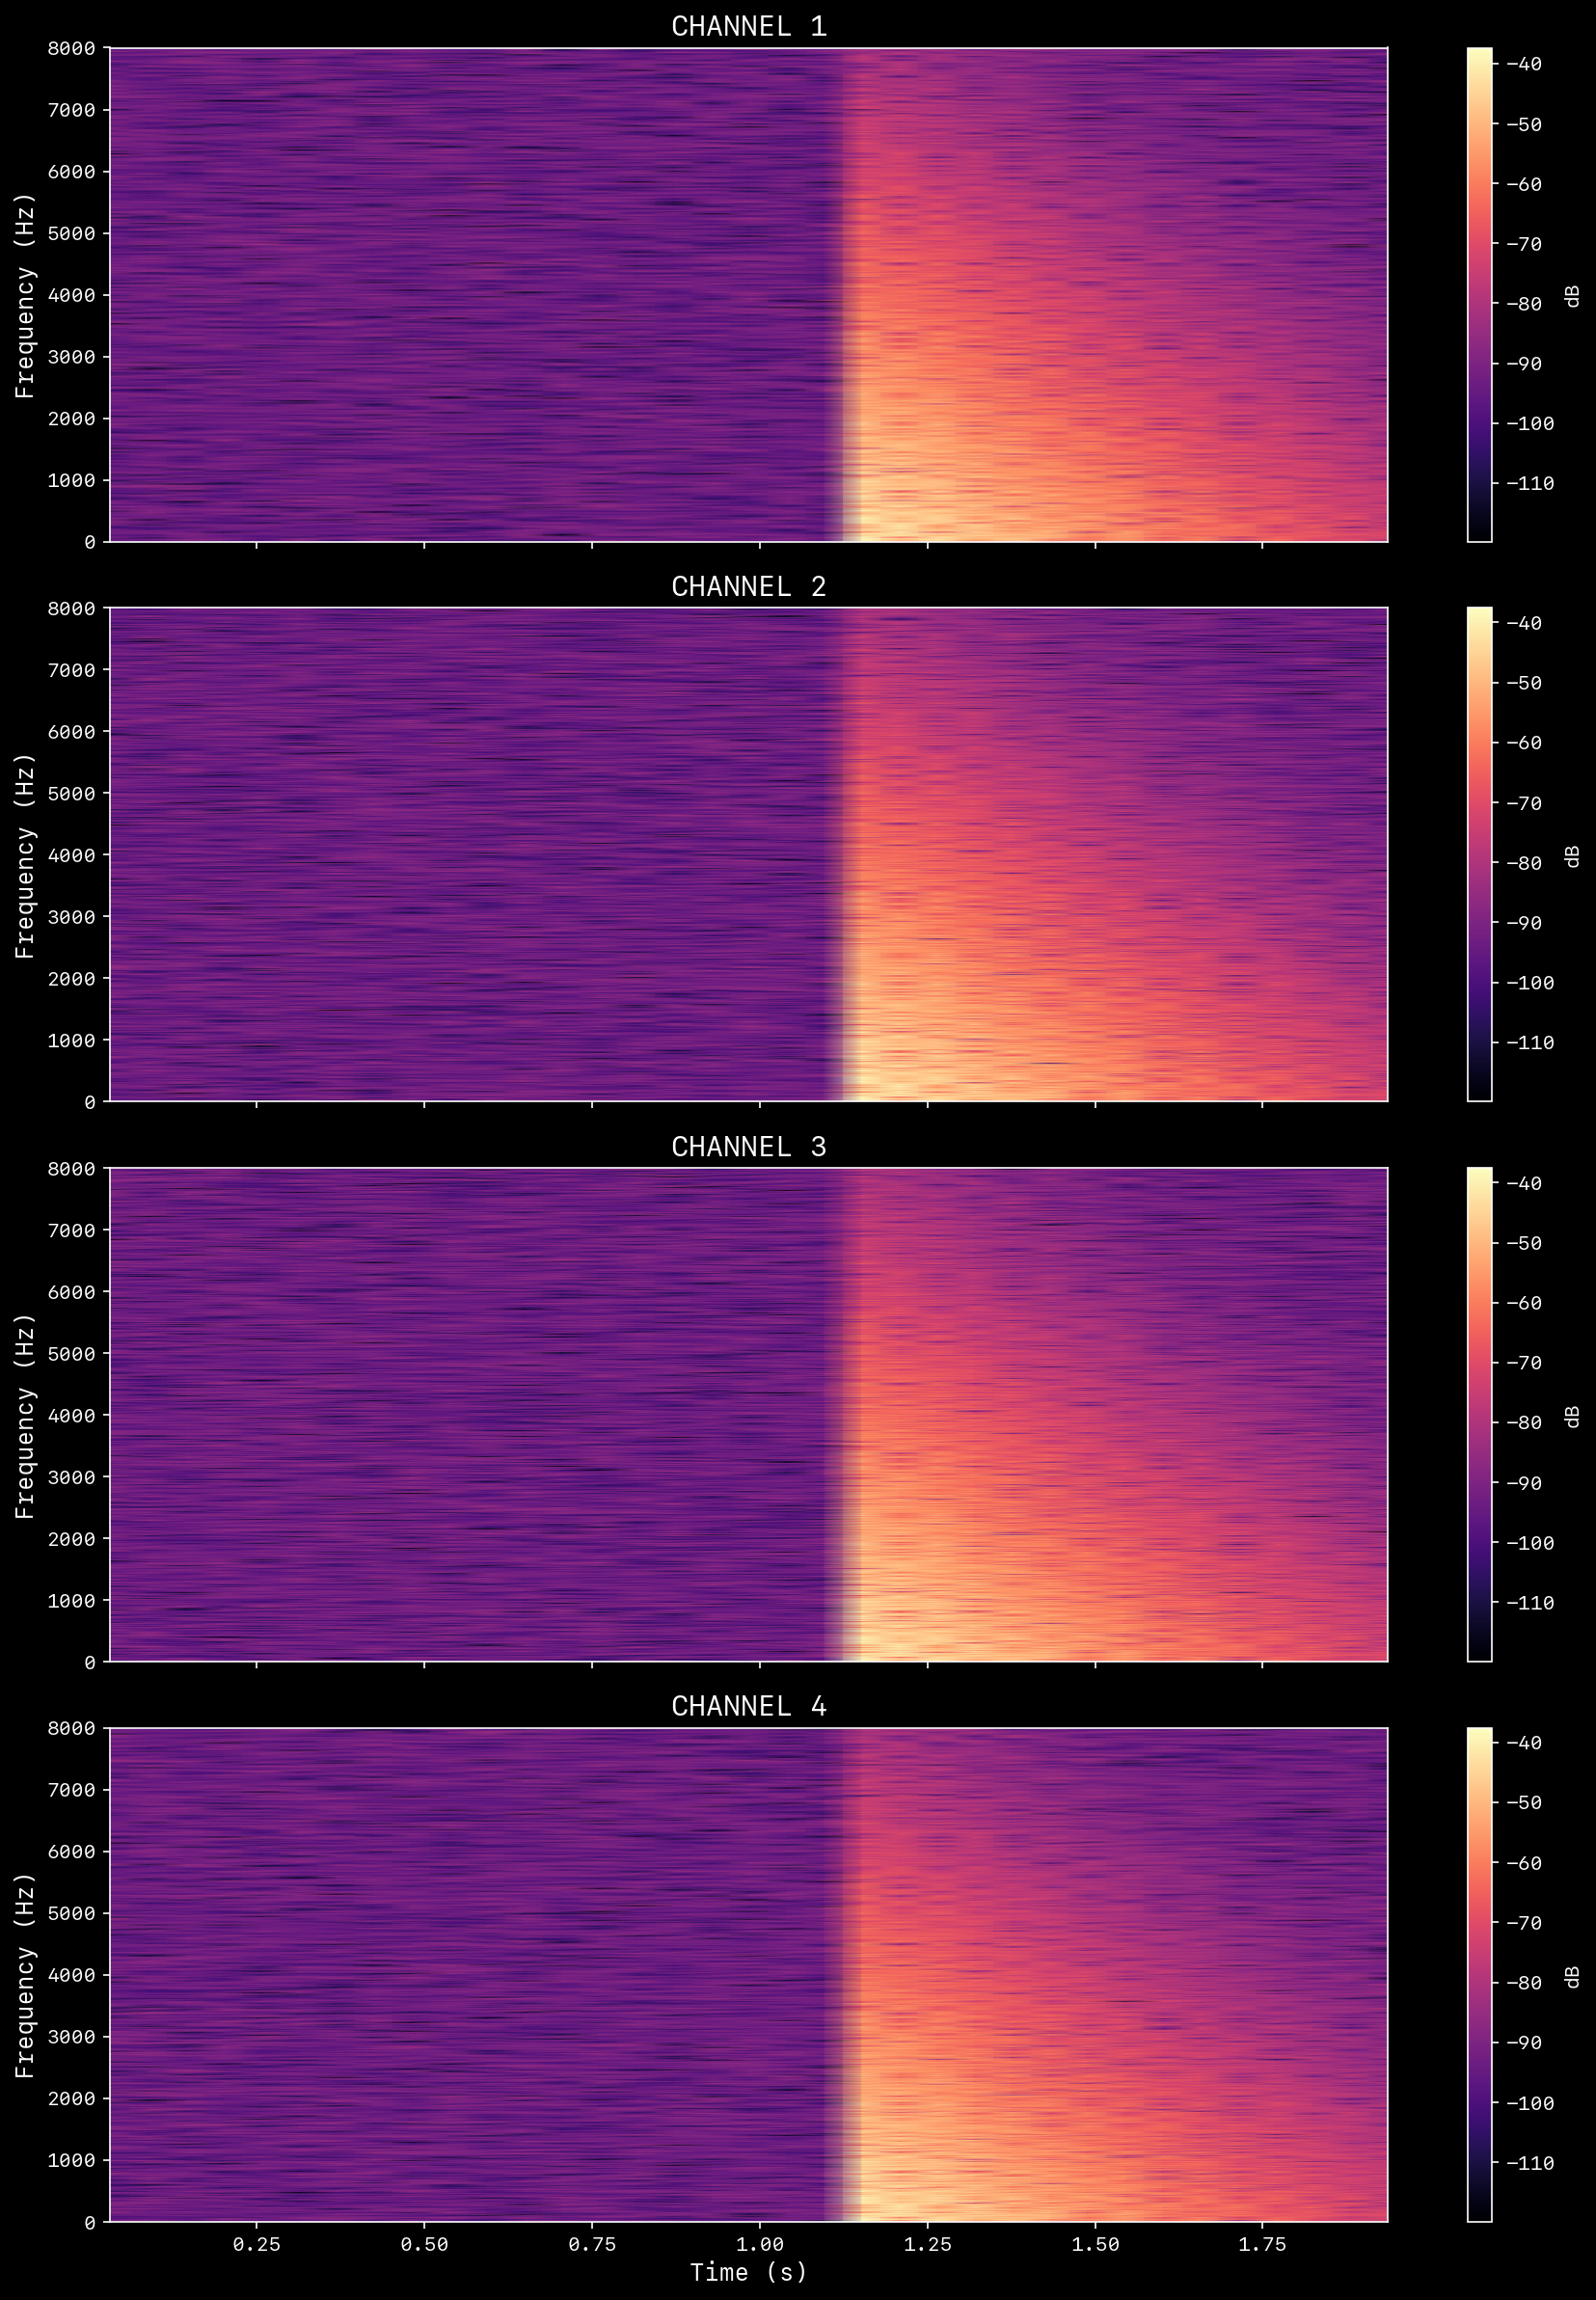

In [135]:
nperseg = 1024

fig, axes = plt.subplots(NUM_CHANNELS, 1, figsize=(12, 4 * NUM_CHANNELS), dpi=150, sharex=True)
if NUM_CHANNELS == 1:
    axes = [axes]

for ch in range(NUM_CHANNELS):
    f_spec, t_spec, Sxx = spectrogram(audio_data[ch], SAMPLE_RATE, nperseg=nperseg)
    Sxx_dB = 10 * np.log10(Sxx + 1e-12)
    im = axes[ch].pcolormesh(t_spec, f_spec, Sxx_dB, shading='gouraud', cmap='magma')
    axes[ch].set_ylabel('Frequency (Hz)', fontfamily=sf_mono_font, fontsize=12)
    axes[ch].set_title(f'CHANNEL {ch + 1}', fontfamily=sf_mono_font, fontsize=14)
    fig.colorbar(im, ax=axes[ch], label='dB')

axes[-1].set_xlabel('Time (s)', fontfamily=sf_mono_font, fontsize=12)
plt.tight_layout()
plt.show()

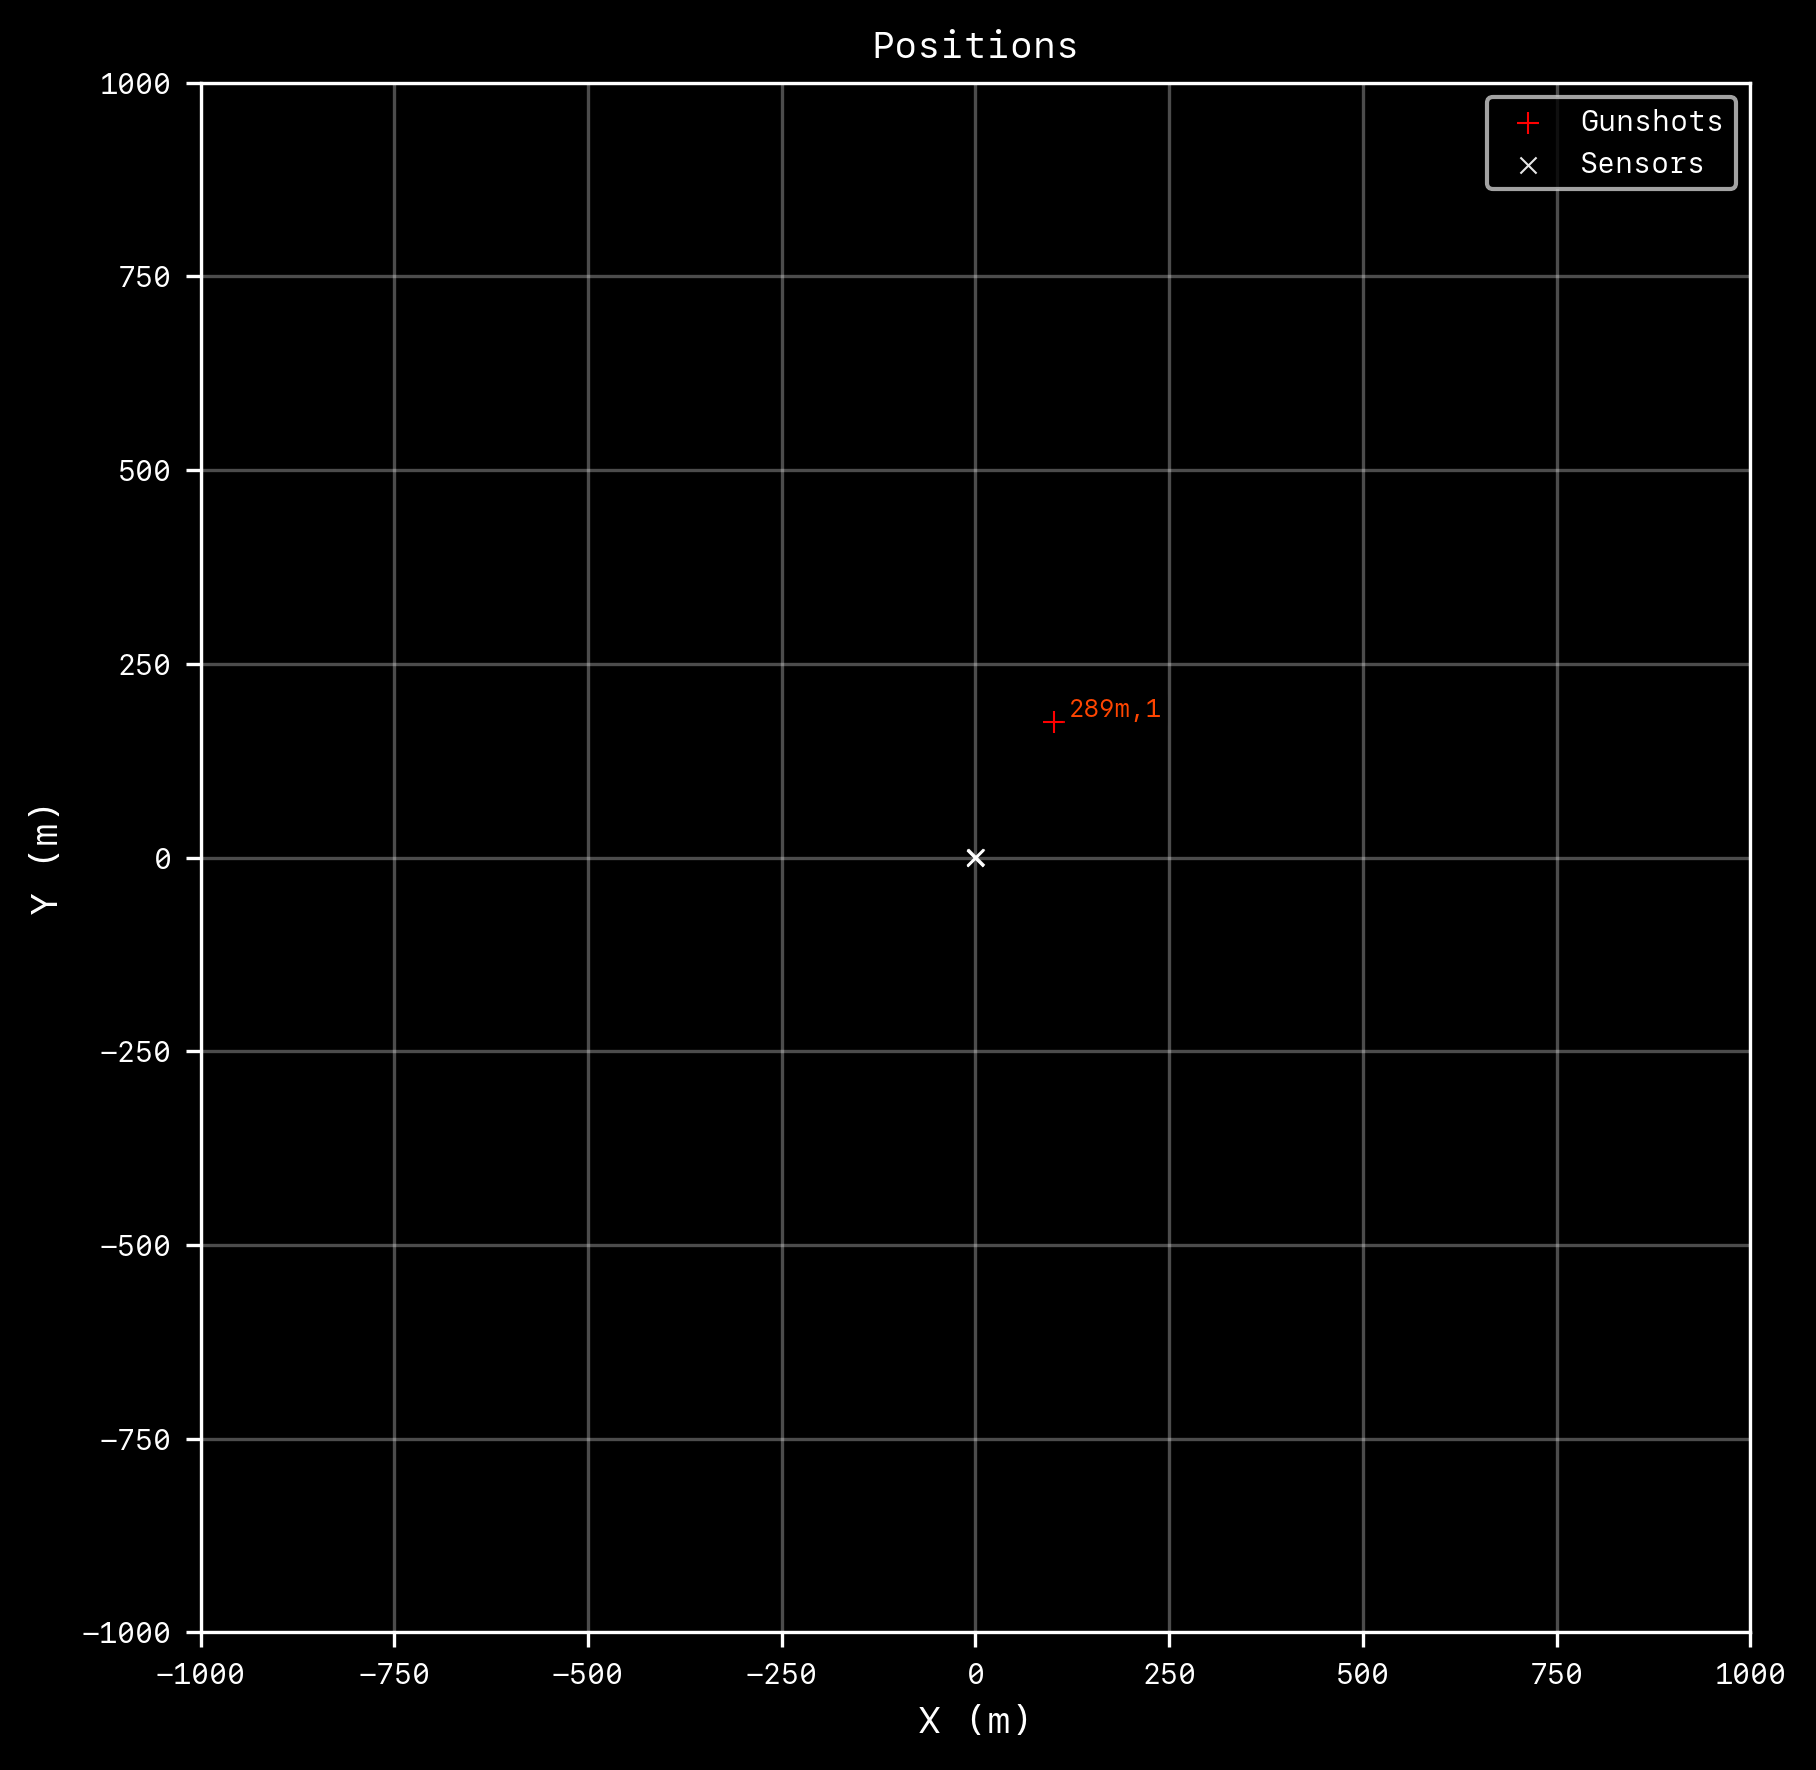

In [136]:
# Plot each gunshot source and sensors in XY plane
while True:
    if 'gunshot_events' in locals():
        events = gunshot_events
    else:
        print("Gunshot event data missing")
        break

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

    # Plot all gunshot positions
    for i, event in enumerate(events):
        pos = event['position']
        # Assign a color/map for each event for distinction
        color = 'red' if len(events) == 1 else plt.cm.rainbow(i / max(1, len(events)-1))
        label = 'Gunshots' if i == 0 else None
        ax.scatter(pos[0], pos[1], color='red', s=30, label=label, zorder=5, marker='+', linewidths=0.5)
        # Annotate the height (z component) at the gunshot source with SF Mono
        gunshot_z = pos[2]
        ax.text(
            pos[0] + 20,
            pos[1],
            f"{gunshot_z:.0f}m,{i+1}",
            color='orangered',
            fontfamily=sf_mono_font,
            fontsize=6,
            ha='left',
            va='bottom',
            zorder=10,
            bbox=dict(facecolor='black', alpha=0.2, edgecolor='none', boxstyle='round,pad=0.23')
        )

    ax.scatter(sensor_positions[:, 0], sensor_positions[:, 1], color='white', s=15, label='Sensors', alpha=0.9, marker='x', linewidths=0.5)

    ax.set_xlabel('X (m)', fontfamily=sf_mono_font, fontsize=9)
    ax.set_ylabel('Y (m)', fontfamily=sf_mono_font, fontsize=9)
    ax.set_title('Positions', fontfamily=sf_mono_font, fontsize=9)
    ax.set_xlim(-1000, 1000)
    ax.set_ylim(-1000, 1000)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=7)
    ax.tick_params(axis='both', which='major', labelsize=7)
    plt.tight_layout()
    plt.show()
    break

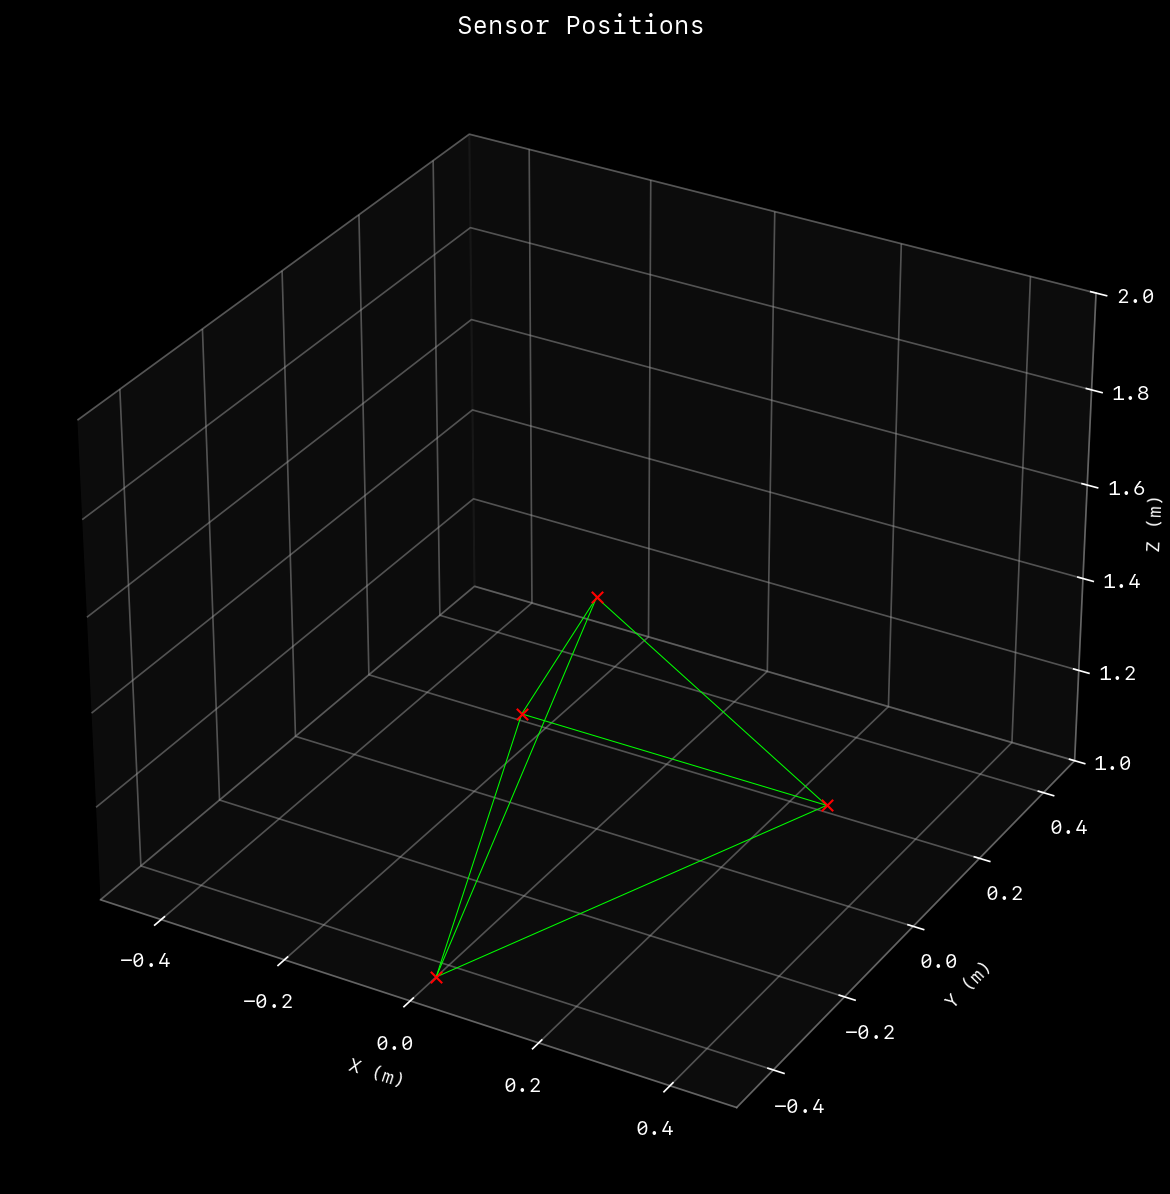

In [137]:
# Plot the sensors in 3D and join all points with pairwise lines
while True:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Reduce axis face colors alpha to 0.01 using modern attribute names
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.05))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.05))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.05))

    # Make axis lines lighter
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_color((0.5, 0.5, 0.5, 0.75))
        axis._axinfo["grid"]['color'] = (0.6, 0.6, 0.6, 0.5)  # lighter grid lines

    # Plot sensors with single marker edge (avoiding overpaint, some "x" seem darker when lines overlap)
    for x, y, z in sensor_positions:
        ax.scatter(x, y, z, color='red', s=30, marker='x', linewidths=1.0, zorder=10)

    # Join all points with pairwise lines
    import itertools
    n_sensors = sensor_positions.shape[0]
    for i, j in itertools.combinations(range(n_sensors), 2):
        x_coords = [sensor_positions[i, 0], sensor_positions[j, 0]]
        y_coords = [sensor_positions[i, 1], sensor_positions[j, 1]]
        z_coords = [sensor_positions[i, 2], sensor_positions[j, 2]]
        ax.plot(x_coords, y_coords, z_coords, color='lime', linewidth=0.5, alpha=1.0, zorder=1)

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(1, 2)

    ax.set_xlabel('X (m)', fontfamily=sf_mono_font, fontsize=9)
    ax.set_ylabel('Y (m)', fontfamily=sf_mono_font, fontsize=9)
    # Pad right side for Z label by moving label outwards
    ax.set_zlabel('Z (m)', fontfamily=sf_mono_font, fontsize=9, labelpad=0)
    ax.set_title('Sensor Positions', fontfamily=sf_mono_font, fontsize=12)

    # Add right margin to ensure z-label and ticks fit
    fig.subplots_adjust(right=0.88)
    break